In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
os.chdir("../")
print(os.getcwd())

kolmo_flow_closure = "Data/Kolmogorov/kolmo_100s_8traj.npy"
kolmo_flow_filtered = "Data/Kolmogorov/kolmo_filtered_100s_8ens.npy"

Phi_f = np.load(kolmo_flow_filtered)
Phi_closure = np.load(kolmo_flow_closure)

print(Phi_f.shape, Phi_closure.shape)

C:\Users\ismae\Desktop\PhD_codes\TurbulentEncoderTransformerDecoder
(8, 800, 8192) (8, 800, 8192)


In [2]:
traj = 7
n_modes = 3
N, T, D = Phi_f.shape

In [3]:
Phi_filtered = Phi_f[traj] 

U, s, Vt = np.linalg.svd(Phi_filtered.T, full_matrices=False)
a = np.diag(s)@Vt

print(U.shape, a.shape) 

(8192, 800) (800, 800)


In [4]:
proj_f = U[:, :n_modes]
coords_f = a[:n_modes, :].T

In [5]:
Phi_c = Phi_closure[traj]
U, s, Vt = np.linalg.svd(Phi_c.T, full_matrices=False)
a = np.diag(s)@Vt

In [6]:
proj_c = U[:, :n_modes]
coords_c = a[:n_modes, :].T

Training GPR model for output dimension 1
Training GPR model for output dimension 2
Training GPR model for output dimension 3
Mean Squared Error on test set: 0.00673225


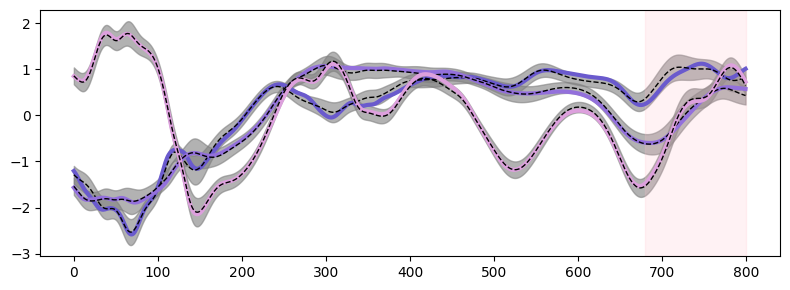

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(coords_f, coords_c, test_size=0.15, shuffle=False)

kernel = C(1.0, (1e-1, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-1, 1e3))

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
coords_f_scaled = scaler_X.transform(coords_f)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
coords_c_scaled = scaler_y.transform(coords_c)

gpr_models = []
y_preds = np.zeros_like(y_test)

for dim in range(n_modes):
    print(f'Training GPR model for output dimension {dim+1}')
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1)
    gpr.fit(X_train_scaled, y_train_scaled[:, dim])
    y_preds[:, dim] = gpr.predict(X_test_scaled)
    gpr_models.append(gpr)

mse = mean_squared_error(y_test_scaled, y_preds)
print(f'Mean Squared Error on test set: {mse:.8f}')


colors = ['slateblue', 'mediumpurple', 'plum', 'cornflowerblue', 'grey', 'pink']
plt.figure(figsize=(8,3))

for dim in range(n_modes):
    y_mean, y_std = gpr_models[dim].predict(coords_f_scaled, return_std=True)
    y_true = coords_c_scaled[:, dim]
    plt.plot(y_true, color=colors[dim], linestyle='-', linewidth=3, label=f'True Reduced Manifold Dimension {dim + 1}')
    plt.plot(y_mean, color='black', linestyle='--', linewidth=1, label=f'Predicted Reduced Manifold Dimension {dim + 1}')

    lower = y_mean - 1.96 * y_std
    upper = y_mean + 1.96 * y_std
    plt.fill_between(np.arange(len(y_mean)), lower, upper, color="grey", alpha=0.6)

plt.axvspan(0.85*T, T, color='pink', alpha=0.2, label='Test set')


plt.title("")
plt.xlabel("")
plt.ylabel("")
# plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import norm

for dim in range(n_modes):
    
    y_mean, y_std = gpr_models[dim].predict(coords_f_scaled, return_std=True)
    y_true = coords_c_scaled[:, dim]
    y_mean, y_std, y_true = y_mean[int(0.85*T):], y_std[int(0.85*T):], y_true[int(0.85*T):]

    rel_L1 = np.sum(np.abs(y_true - y_mean)) / np.sum(np.abs(y_true))
    rel_L2 = np.sqrt(np.sum((y_true - y_mean)**2)) / np.sqrt(np.sum(y_true**2))

    standardized = (y_true - y_mean) / y_std
    crps_values = y_std * (1/np.sqrt(np.pi) - 2*norm.pdf(standardized) -
                          standardized * (2*norm.cdf(standardized) - 1))
    crps = np.mean(crps_values)

    lower = y_mean - y_std
    upper = y_mean + y_std
    coverage_sigma = np.mean((y_true >= lower) & (y_true <= upper))

    lower = y_mean - 2*y_std
    upper = y_mean + 2*y_std
    coverage_2_sigma = np.mean((y_true >= lower) & (y_true <= upper))

    lower = y_mean - 3*y_std
    upper = y_mean + 3*y_std
    coverage_3_sigma = np.mean((y_true >= lower) & (y_true <= upper))

    print(f"Dimension {dim+1}:")
    print(f"  Relative L1 loss: {rel_L1:.4f}")
    print(f"  Relative L2 loss: {rel_L2:.4f}")
    print(f"  CRPS: {crps:.4f}")
    print(f"  PICP (±1σ): {coverage_sigma:.4f}")
    print(f"  PICP (±2σ): {coverage_2_sigma:.4f}")
    print(f"  PICP (±3σ): {coverage_3_sigma:.4f}")

Dimension 1:
  Relative L1 loss: 0.1216
  Relative L2 loss: 0.1382
  CRPS: -0.0701
  PICP (±1σ): 0.5500
  PICP (±2σ): 1.0000
  PICP (±3σ): 1.0000
Dimension 2:
  Relative L1 loss: 0.0963
  Relative L2 loss: 0.1169
  CRPS: -0.0376
  PICP (±1σ): 0.9333
  PICP (±2σ): 1.0000
  PICP (±3σ): 1.0000
Dimension 3:
  Relative L1 loss: 0.0663
  Relative L2 loss: 0.0633
  CRPS: -0.0354
  PICP (±1σ): 1.0000
  PICP (±2σ): 1.0000
  PICP (±3σ): 1.0000


In [9]:
ensemble_size = 100
test_size = int(0.15*T)
z_ensemble = np.zeros((test_size, n_modes, ensemble_size))
z_true = np.zeros((test_size, n_modes))

for dim in range(n_modes):
    
    y_mean, y_std = gpr_models[dim].predict(coords_f_scaled, return_std=True)
    y_true = coords_c_scaled[:, dim]
    
    y_mean, y_std, y_true = y_mean[int(0.85*T):], y_std[int(0.85*T):], y_true[int(0.85*T):]
    z_true[:, dim] = y_true
    
    samples = np.random.normal(loc=y_mean[:, np.newaxis], scale=y_std[:, np.newaxis], size=(test_size, ensemble_size))
    z_ensemble[:, dim, :] = samples


Phi_ensemble = np.tensordot(z_ensemble, proj_c.T, axes=([1], [0]))  

Phi_mean = np.mean(Phi_ensemble, axis=1)
Phi_std = np.std(Phi_ensemble, axis=1)  


Phi_true = np.dot(z_true, proj_c.T)     


rel_L1 = np.sum(np.abs(Phi_true - Phi_mean)) / np.sum(np.abs(Phi_true)) * 100
rel_L2 = np.sqrt(np.sum((Phi_true - Phi_mean)**2)) / np.sqrt(np.sum(Phi_true**2)) * 100


Phi_lower_sigma = Phi_mean - Phi_std
Phi_upper_sigma = Phi_mean + Phi_std
Phi_lower_3_sigma = Phi_mean - 3*Phi_std
Phi_upper_3_sigma = Phi_mean + 3*Phi_std

coverage_1_sigma = np.mean((Phi_true >= Phi_lower_sigma) & (Phi_true <= Phi_upper_sigma)) * 100
coverage_3_sigma = np.mean((Phi_true >= Phi_lower_3_sigma) & (Phi_true <= Phi_upper_3_sigma)) * 100

standardized = (Phi_true - Phi_mean) / Phi_std
crps_values = Phi_std * (1/np.sqrt(np.pi) - 2*norm.pdf(standardized) -
                          standardized * (2*norm.cdf(standardized) - 1))
crps = np.mean(crps_values)

print(f"  Relative L1 loss: {rel_L1:.2f}%")
print(f"  Relative L2 loss: {rel_L2:.2f}%")
print(f"  PICP (±1σ): {coverage_1_sigma:.2f}%")
print(f"  PICP (±3σ): {coverage_3_sigma:.2f}%")
print(f"  CRPS: {np.abs(crps):.4f}")

  Relative L1 loss: 10.13%
  Relative L2 loss: 11.44%
  PICP (±1σ): 82.50%
  PICP (±3σ): 100.00%
  CRPS: 0.0009


In [139]:
kolmo_flow_inference = "Data/Kolmogorov/kolmo_filtered_400s_inference.npy"
kolmo_flow_closure_120 = "Data/Kolmogorov/kolmo_120s_8traj.npy"
Phi_inference = np.load(kolmo_flow_inference)
Phi_closure_120 = np.load(kolmo_flow_closure_120)[:, 1::2, :]
print(Phi_inference.shape, Phi_closure_120.shape)

(1, 1601, 8192) (8, 500, 8192)


In [140]:
T_inference = Phi_inference.shape[1] 
T_truth = Phi_closure_120.shape[1] 

In [141]:
ensemble_size =  100 
Phi_f_hat = Phi_inference[0]
coords_inf = Phi_f_hat @ proj_f
coords_inf_scaled = scaler_X.transform(coords_inf)

z_ensemble = np.zeros((T_inference, n_modes, ensemble_size))
z_ensemble_unscaled = np.zeros((T_inference, n_modes, ensemble_size))

for dim in range(3):
    
    y_mean, y_std = gpr_models[dim].predict(coords_inf_scaled, return_std=True)
      
    samples = np.random.normal(loc=y_mean[:, np.newaxis], scale=y_std[:, np.newaxis], size=(T_inference, ensemble_size))
    z_ensemble[:, dim, :] = samples
    
for ens in range(ensemble_size) : 
    
    coords_closure_hat = scaler_y.inverse_transform(z_ensemble[:, :, ens])
    z_ensemble_unscaled[:, :, ens] = coords_closure_hat

Phi_ensemble_inference = np.tensordot(z_ensemble_unscaled, proj_c.T, axes=([1], [0]))  

Phi_mean_inference = np.mean(Phi_ensemble_inference, axis=1)
Phi_std_inference = np.std(Phi_ensemble_inference, axis=1)  

print(Phi_mean_inference.shape, Phi_std_inference.shape)

(1601, 8192) (1601, 8192)


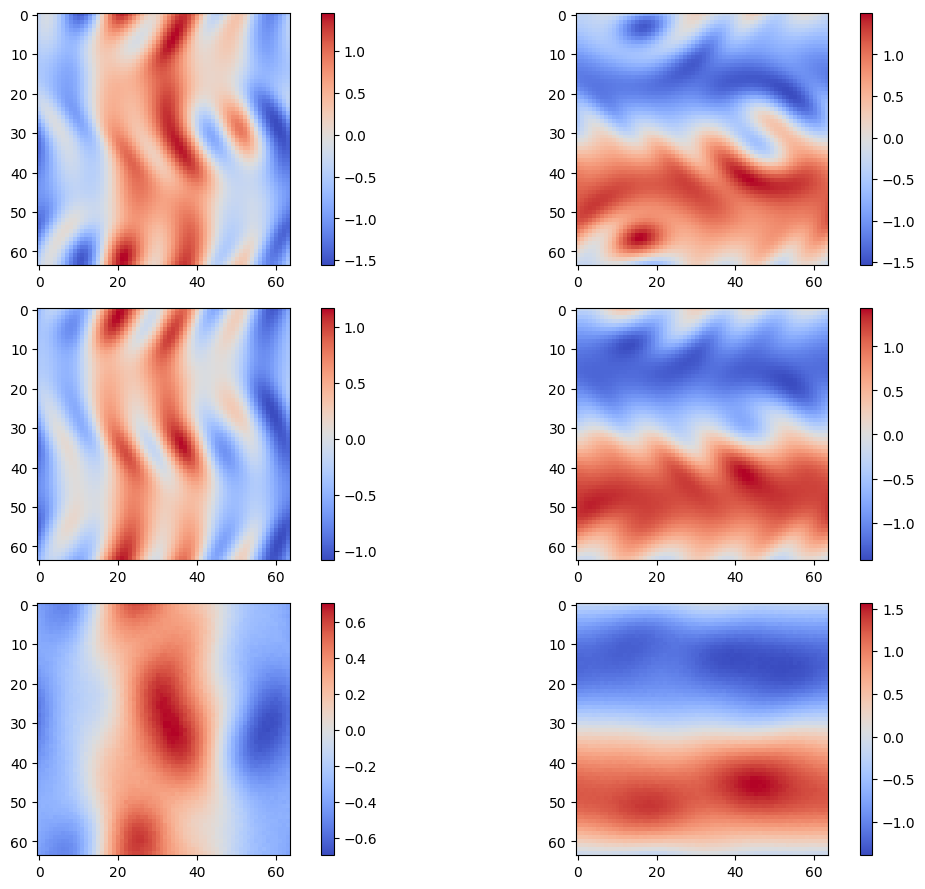

In [142]:
ny, ny = int(np.sqrt(D//2)),  int(np.sqrt(D//2))
U_closed_inference = Phi_mean_inference[:, :D//2] 
V_closed_inference = Phi_mean_inference[:, D//2:] 
U_closed_inference = U_closed_inference.reshape(T_inference, ny, ny)
V_closed_inference = V_closed_inference.reshape(T_inference, ny, ny)

U_inference = Phi_inference[0, :, :D//2] 
V_inference = Phi_inference[0, :, D//2:] 
U_inference = U_inference.reshape(T_inference, ny, ny)
V_inference = V_inference.reshape(T_inference, ny, ny)

U_closed = Phi_closure_120[traj, :, :D//2] 
V_closed = Phi_closure_120[traj, :, D//2:] 
U_closed = U_closed.reshape(T_truth, ny, ny)
V_closed = V_closed.reshape(T_truth, ny, ny)

snapshot = 400
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

im0 = axes[0, 0].imshow(U_closed[snapshot], cmap='coolwarm')
fig.colorbar(im0, ax=axes[0, 0])


im1 = axes[0, 1].imshow(V_closed[snapshot], cmap='coolwarm')
fig.colorbar(im1, ax=axes[0, 1])

im2 = axes[1, 0].imshow(U_closed_inference[snapshot], cmap='coolwarm')
fig.colorbar(im2, ax=axes[1, 0])

im3 = axes[1, 1].imshow(V_closed_inference[snapshot], cmap='coolwarm')
fig.colorbar(im3, ax=axes[1, 1])

im4 = axes[2, 0].imshow(U_inference[snapshot], cmap='coolwarm')
fig.colorbar(im4, ax=axes[2, 0])

im5 = axes[2, 1].imshow(V_inference[snapshot], cmap='coolwarm')
fig.colorbar(im5, ax=axes[2, 1])

plt.tight_layout()
plt.show()

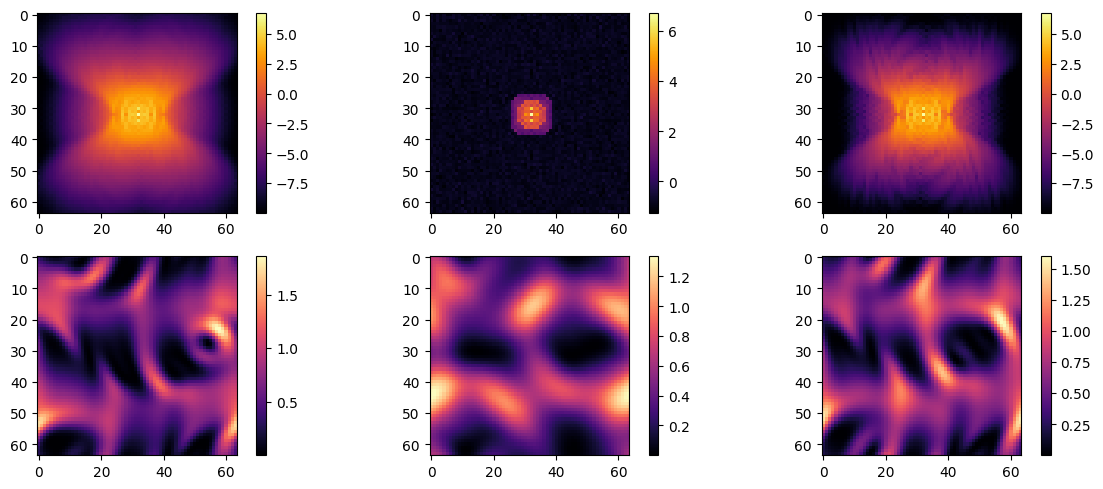

In [143]:
def average_energy_spectrum(field):
    fft_field = np.fft.fft2(field, axes=(1, 2))
    energy = np.abs(fft_field) ** 2
    avg_energy = np.mean(energy, axis=0)
    return np.fft.fftshift(avg_energy)


E_closed_inference = 0.5*(U_closed_inference**2 + V_closed_inference**2)
E_closed = 0.5*(U_closed**2 + V_closed**2)
E_inference = 0.5*(U_inference**2 + V_inference**2)

E_c = average_energy_spectrum(E_closed)
E_hat_c = average_energy_spectrum(E_closed_inference )
E_hat_f = average_energy_spectrum(E_inference)

timestep = 120

plt.figure(figsize=(12, 5))

plt.subplot(2,3, 1)
plt.imshow(np.log10(E_c + 1e-10), cmap='inferno')

plt.colorbar()

plt.subplot(2, 3, 2)
plt.imshow(np.log10(E_hat_f + 1e-10), cmap='inferno')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.imshow(np.log10(E_hat_c + 1e-10), cmap='inferno')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.imshow(E_closed[timestep, :, :], cmap='magma')
plt.colorbar()
plt.subplot(2, 3, 5)
plt.imshow(E_inference[timestep, :, :], cmap='magma')
plt.colorbar()
plt.subplot(2, 3, 6)
plt.imshow(E_closed_inference[timestep, :, :], cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()

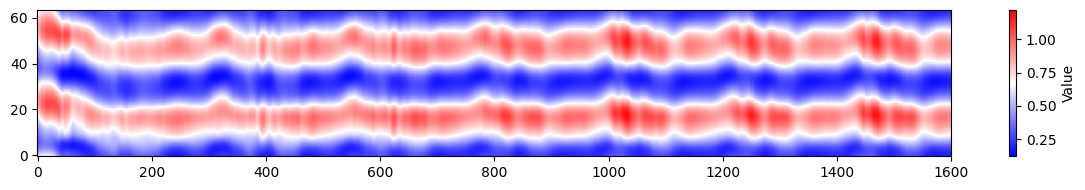

In [144]:
from scipy.interpolate import interp1d

T, nx, ny = U_closed_inference.shape

k_closed_inference = 0.5*(U_closed_inference**2 + V_closed_inference**2)
k_downsampled = np.mean(k_closed_inference, axis = -1) 

plt.figure(figsize=(12, 2))
plt.imshow(k_downsampled.T, aspect='auto', cmap='bwr', origin='lower')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

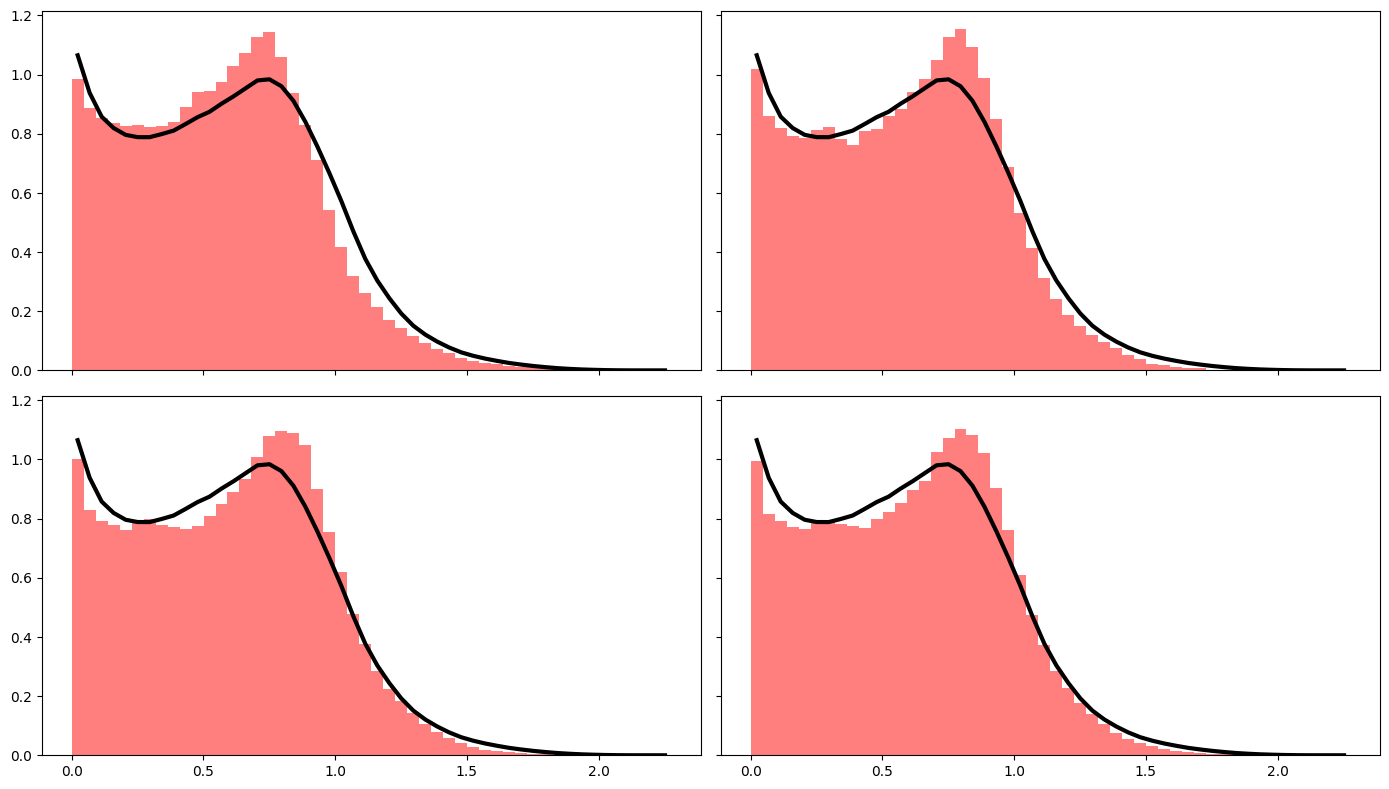

In [154]:
U_closed = Phi_closure_120[:, :, :D//2] 
V_closed = Phi_closure_120[:, :, D//2:] 

k_closed = 0.5*(U_closed**2 + V_closed**2)
k_closed_flat = k_closed.flatten()
bins = 50
range_min = min(k_closed_flat.min(), k_closed_inference.min())
range_max = max(k_closed_flat.max(), k_closed_inference.max())
hist_range = (range_min, range_max)

pdf_ref, bin_edges = np.histogram(k_closed_flat, bins=bins, range=hist_range, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(4):
    start = i * 400
    end = start + 400
    slice_data = k_closed_inference[start:end, :].flatten()

    pdf_slice, _ = np.histogram(slice_data, bins=bin_edges, density=True)

    ax = axes[i]
    ax.bar(bin_centers, pdf_slice, width=bin_edges[1]-bin_edges[0], 
           color='red', alpha=0.5, label=f"Slice {i+1} (rows {start}-{end})")

    ax.plot(bin_centers, pdf_ref, color='black', linewidth=3, label='Reference')


plt.tight_layout()
plt.show()

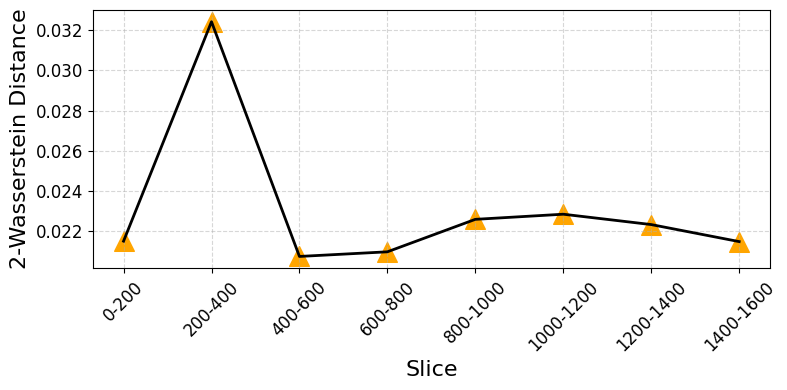

In [155]:
from scipy.stats import wasserstein_distance, energy_distance
wd_values_k = []

for i in range(8):
    start = i * 200
    end = start + 200
    slice_data_k = k_closed_inference[start:end, :].flatten()
    wd_k = wasserstein_distance(slice_data_k, k_closed_flat)
    wd_values_k.append(wd_k)

plt.figure(figsize=(8, 4))
x = ['0-200', '200-400', '400-600', '600-800', '800-1000', '1000-1200', '1200-1400', '1400-1600']
# x = np.arange(1, 6)
plt.plot(x, wd_values_k, color='black', linewidth=2)
plt.scatter(x, wd_values_k, marker = '^',s = 200, color = 'orange', label='1-Wasserstein Distance (Energy)')

plt.ylabel("2-Wasserstein Distance", fontsize = 16)
plt.xlabel("Slice", fontsize = 16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

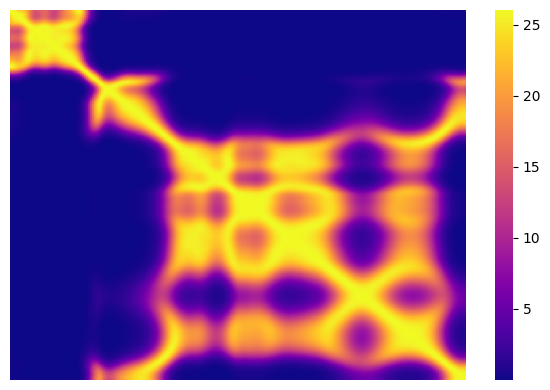

In [129]:
import seaborn as sns  # Make sure seaborn is imported

K = gpr.kernel_(X_train)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(K, cmap='plasma')

num_ticks = 0
n = K.shape[0]
tick_positions = np.linspace(0, n, num_ticks, dtype=int)

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_positions)

ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_positions)

# Improve layout
plt.tight_layout()
plt.show()
